# Exploratory Data Analysis - DSB 2018

## Introduction

Identifying the cells’ nuclei is the starting point for most analyses because most of the human body’s 30 trillion cells contain a nucleus full of DNA, the genetic code that programs each cell. Identifying nuclei allows researchers to identify each individual cell in a sample, and by measuring how cells react to various treatments, the researcher can understand the underlying biological processes at work.

This is an exploratory analysis with the goal of becoming more familiar with the 2018 Data Science Bowl dataset and identifying some possible hurdles that could have a negative effect on model performance.

**Contents:**
<li>Importing and processing image data</li>
<li>Plotting a sample of train images</li>
<li>Plotting a sample of test images</li>
<li>Microscope image types clustering</li>
<li>Image Size Distribution</li>
<li>Nuclei per image statistics</li>
<li>Plotting number of nuclei per image distribution</li>
<li>Plotting nuclei main statistics</li>
<li>Conclusion

The list of required python libraries for this notebook:

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import random
from tqdm import tqdm
import cv2

## Importing and processing image data##
This dataset contains 670 of segmented nuclei images in train data set and 65 images to be predicted. The images were acquired under a variety of conditions and vary in the cell type, magnification, and imaging modality (brightfield vs. fluorescence). The dataset is designed to challenge an algorithm's ability to generalize across these variations.

Each image is represented by an associated ImageId. Files belonging to an image are contained in a folder with this ImageId. Within this folder are two subfolders:
<li> input/stage1_train/
<li> input/stage1_test/</li>
Images contains the image file. Masks contains the segmented masks of each nucleus. This folder is only included in the training set. Each mask contains one nucleus. Masks are not allowed to overlap (no pixel belongs to two masks).


In addition a RLE-file (Run Length Encoding) **'stage1_train_labels.csv'** includet to folder **input/stage1_train/** where encoded all information about masks related to training set.

RLE or Run Length Encoding converts a matrix into a vector and returns the position/starting point of the first pixel from where we observe an object (identified by a 1) and gives us a count of how many pixels from that pixel we see the series of 1s. In the ndimage.label function example of [1 1 1 0 0 1 1], running RLE would give us 1 3 6 2, which means 3 pixels from the zeroth pixel (inclusive) and 2 pixels from the 5th pixel we see a series of 1s

Read from the RLE-file 3 random chosen images and print it IDs:

In [2]:
input_dir = 'input'
train_dir = 'input/stage1_train'
im_ids = np.unique(pd.read_csv(os.path.join(input_dir, 'stage1_train_labels.csv'), usecols=['ImageId']))
random.sample(list(im_ids), 3)

['29dd28df98ee51b4ab1a87f5509538ecc3e4697fc57c40c6165658f61b0d8e3a',
 'e50ac10d1dce6496d092d966784ed3795969128ca0bc58199a36d558ed529203',
 'ecb36c90cdd20245d89173c106f3c6a2d124d07bdea0ae202fb1efa49b0cd169']

Function for image read using **skimage** and it mask. Also for a better visualisation here inplemented an **SOBEL** Edge algorithm detection from **cv2 library** (https://docs.opencv.org/3.2.0/d2/d2c/tutorial_sobel_derivatives.html).

In [3]:
def show_images(image_ids):
  fig, ax = plt.subplots(nrows=len(image_ids),ncols=3, figsize=(20,20))

  for image_idx, image_id in enumerate(image_ids):
    image_path = os.path.join(train_dir, image_id, 'images', '{}.png'.format(image_id))
    mask_paths = os.path.join(train_dir, image_id, 'masks', '*.png')
  
    image = skimage.io.imread(image_path)
    gray_im = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    sob_filter_x = cv2.Sobel(gray_im,int(cv2.CV_64F),1,0,ksize=3)
    sob_filter_y = cv2.Sobel(gray_im,int(cv2.CV_64F),0,1,ksize=3)
    sob_filter_im = np.sqrt(np.square(sob_filter_x) + np.square(sob_filter_y))
    
    masks = skimage.io.imread_collection(mask_paths).concatenate()
    mask = np.zeros(image.shape[:2], np.uint16)
    for mask_idx in range(masks.shape[0]):
      mask[masks[mask_idx] > 0] = mask_idx + 1
    other = mask == 0
    ax[image_idx, 0].imshow(image)
    ax[image_idx, 0].axis('off')
    ax[image_idx, 0].set_title('Real Image')  
    ax[image_idx, 1].imshow(mask)
    ax[image_idx, 1].axis('off')
    ax[image_idx, 1].set_title('Mask')
    ax[image_idx, 2].imshow(sob_filter_im)
    ax[image_idx, 2].set_title('Real Image with Sobel Filter (Edge Markup)')
    ax[image_idx, 2].axis('off')

## Plotting a sample of train images
Read from the **'input/stage1_train/'** folder 3 randomly chosen images:

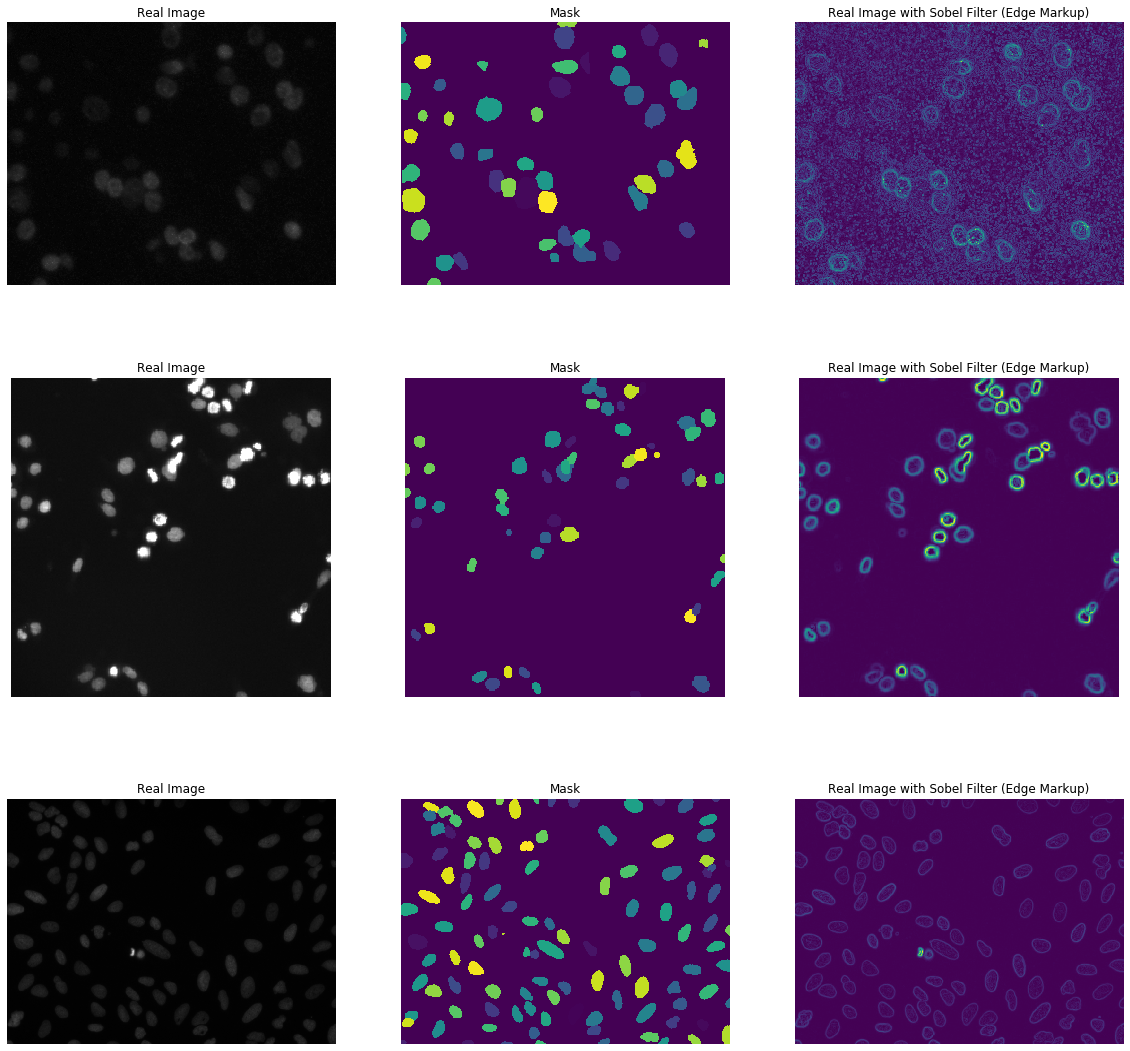

In [4]:
show_images(random.sample(list(im_ids), 3))

## Plotting a sample of test images
Read from the **'input/stage1_test/'** folder 3 randomly chosen images:

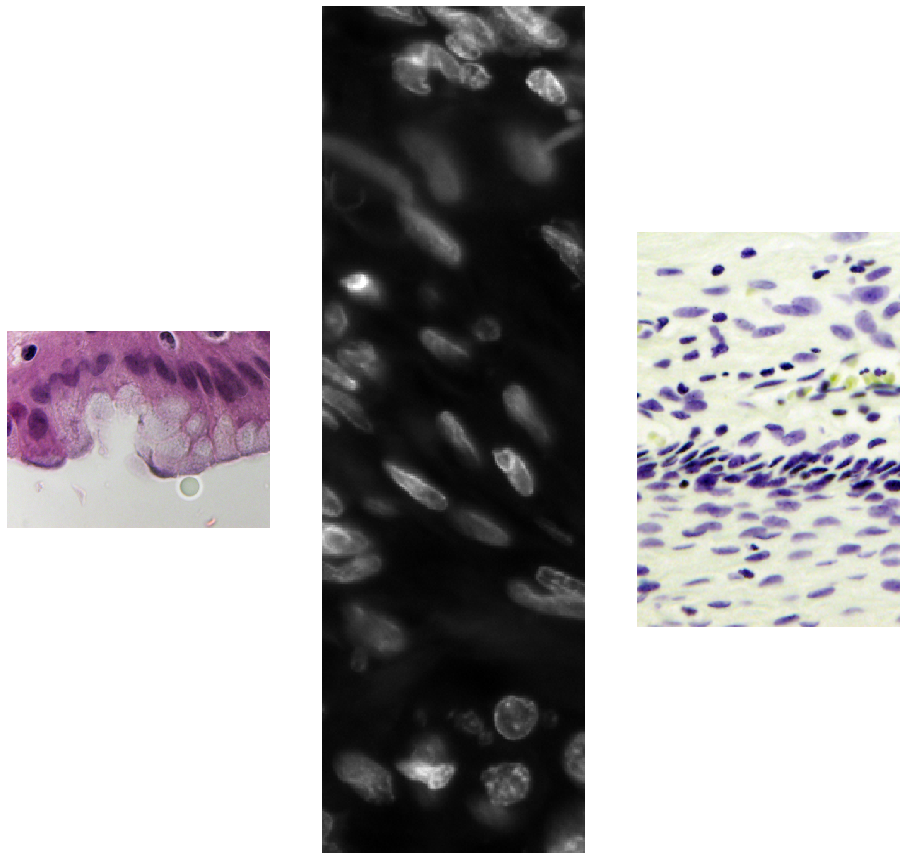

In [5]:
ts_path = 'input/stage1_test/'
test_ids = next(os.walk(ts_path))[1]
test_smpls = random.sample(test_ids, 3)
fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(16,16))
for image_idx, image_id in enumerate(test_smpls):
    image_path = os.path.join(ts_path, image_id, 'images', '{}.png'.format(image_id))
    image = skimage.io.imread(image_path)
    ax[image_idx].imshow(image)
    ax[image_idx].axis('off')   

I had initially glanced through some of the sample images and there were different types of images with variouse sizes.  

Also it was discovered that some were grayscale with black background and nuclei in grayscale intensities. Some of them were in color and some of them seemed to be black on white.
Definitally its going to effect ours prediction results that's why let's discover these image types in the next chaper...

## Microscope image types clustering

So there are at least three different types of images in the dataset, which come from different types of microscopes: Group A are histological slides, group B are fluorescent images, and group C are bright-field images.

Function to read images:

In [6]:
def read_image(image_id, space="rgb"):
    image_file = os.path.join(train_dir, image_id, 'images', '{}.png'.format(image_id))
    image = skimage.io.imread(image_file)
    # Drop alpha which is not used
    image = image[:, :, :3]
    if space == "hsv":
        image = skimage.color.rgb2hsv(image)
    return image

Run KMeans on each image. Centroids provide dominant colors (based on provided colorspace).

In [7]:
def get_domimant_colors(img, top_colors=2):
    img_l = img.reshape((img.shape[0] * img.shape[1], img.shape[2]))
    clt = KMeans(n_clusters = top_colors)
    clt.fit(img_l)
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    return clt.cluster_centers_, hist

Save each clustering arrays to the list details:

In [8]:
from sklearn.cluster import KMeans
details = []
for n, image_id in tqdm(enumerate(im_ids), total=len(im_ids)):
    image_hsv = read_image(image_id, space = "rgb")
    dominant_colors_hsv, dominant_rates_hsv = get_domimant_colors(image_hsv, top_colors=1)
    dominant_colors_hsv = dominant_colors_hsv.reshape(1, dominant_colors_hsv.shape[0] * dominant_colors_hsv.shape[1])
    info = (image_id, dominant_colors_hsv.squeeze())
    details.append(info)

100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [04:49<00:00,  2.31it/s]


And save it to DataFrame, it will help more easy run K-Means clustering algorithm prediction and further analysis

In [9]:
color_clust = pd.DataFrame(details, columns=['im_id', 'hsv_dominant'])
X = (pd.DataFrame(color_clust['hsv_dominant'].values.tolist())).to_numpy()
kmeans = KMeans(n_clusters=3).fit(X)
clusters = kmeans.predict(X)
color_clust['hsv_cluster'] = clusters

Resulting DataFrame with addition column "hsv_cluster" after K-Means algorithm

In [10]:
color_clust.head()

,im_id,hsv_dominant,hsv_cluster
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,"[6.1422271728515625, 6.1422271728515625, 6.142...",0
1,003cee89357d9fe13516167fd67b609a164651b2193458...,"[9.018600463867188, 9.018600463867188, 9.01860...",0
2,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,"[177.30477294921747, 154.22296142578125, 193.0...",1
3,0121d6759c5adb290c8e828fc882f37dfaf3663ec885c6...,"[179.2233764648449, 169.04213867187244, 204.67...",2
4,01d44a26f6680c42ba94c9bc6339228579a95d0e2695b1...,"[175.12152099609375, 154.26209716797607, 200.5...",1


Image plot function

In [11]:
def plot_images(images, images_rows, images_cols):
    f, axarr = plt.subplots(images_rows,images_cols,figsize=(16,images_rows*2))
    for row in range(images_rows):
        for col in range(images_cols):
            image_id = images[row*images_cols + col]
            image = read_image(image_id)
            height, width, l = image.shape
            ax = axarr[row,col]
            ax.axis('off')
            ax.imshow(image)

Ploting images from Group A are  - histological slides

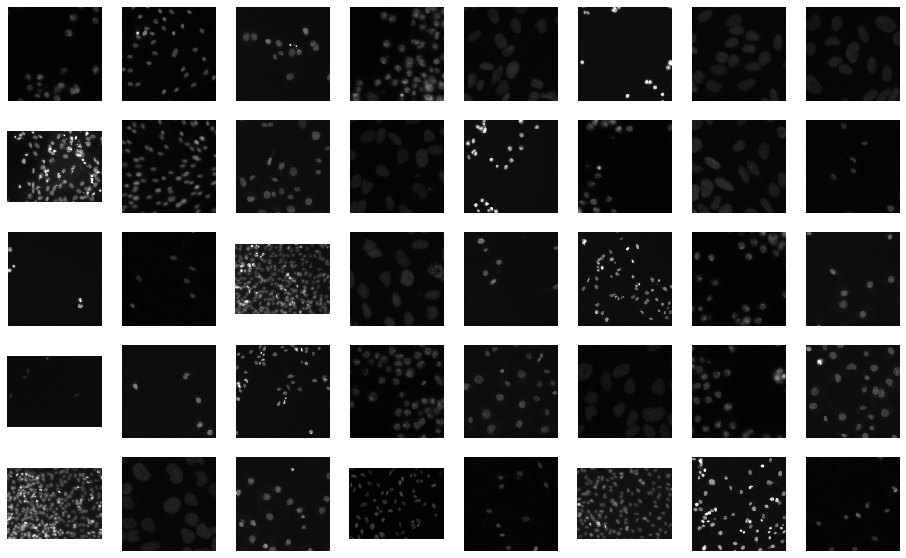

In [12]:
plot_images(color_clust[color_clust['hsv_cluster'] == 0]['im_id'].values, 5, 8)

Ploting images from group B - fluorescent images

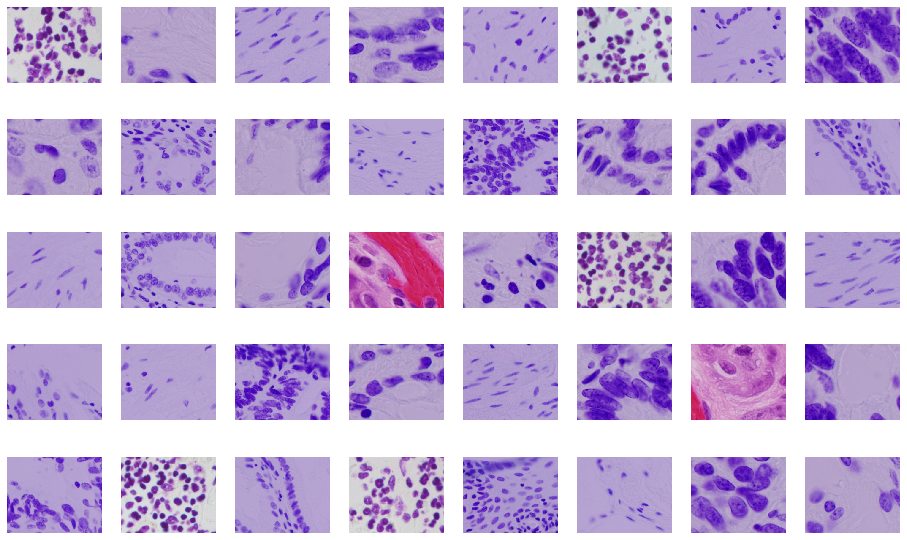

In [13]:
plot_images(color_clust[color_clust['hsv_cluster'] == 1]['im_id'].values, 5, 8)

Ploting images from group C - bright-field images.

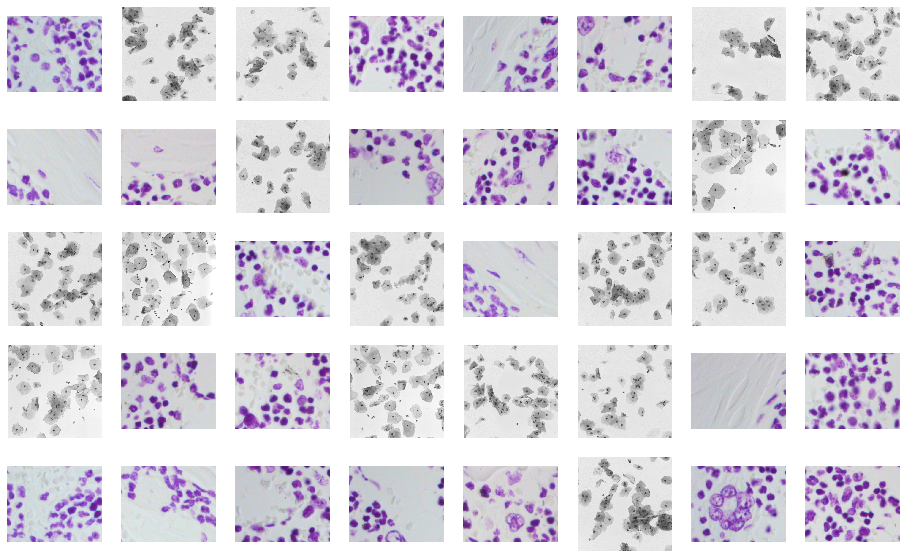

In [14]:
plot_images(color_clust[color_clust['hsv_cluster'] == 2]['im_id'].values, 5, 8)

And summarizing statistics (in percentile):

In [15]:
counts = color_clust.groupby('hsv_cluster')['im_id'].count().reset_index()
counts['Perc'] = 100*counts['im_id']/counts['im_id'].sum()
counts

,hsv_cluster,im_id,Perc
0,0,546,81.492537
1,1,82,12.238806
2,2,42,6.268657


## Image Size Distribution ##

In [16]:
tr_size_lst=[]
for image_idx, image_id in enumerate(im_ids):
    image_path = os.path.join(train_dir, image_id, 'images', '{}.png'.format(image_id))
    image = skimage.io.imread(image_path)
    tr_size_lst.append(str(list(image[:,:,0].shape)))
tr_unique, tr_counts = np.unique(tr_size_lst, return_counts=True)

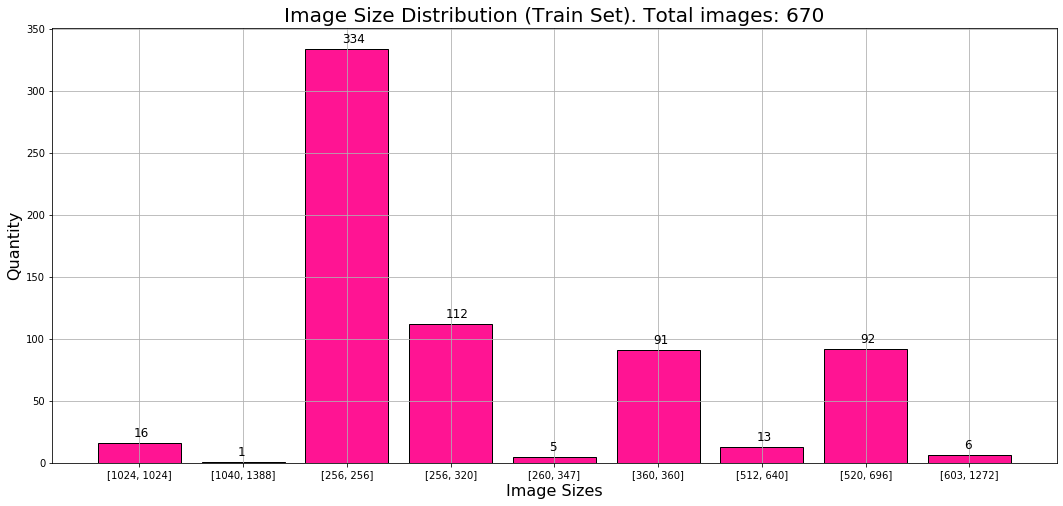

In [17]:
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(18,8))
ax.bar(tr_unique, tr_counts, color='deeppink', edgecolor='black')  # `density=False` would make counts
ax.set_title('Image Size Distribution (Train Set). ' + 'Total images: ' + str(len(tr_size_lst)), fontsize=20)
ax.set_ylabel('Quantity', fontsize=16)
ax.set_xlabel('Image Sizes', fontsize=16);
ax.grid()
for i in range(len(tr_counts)):
    ax.text(i-.05, tr_counts[i]+5, tr_counts[i], fontsize=12)

In [18]:
ts_size_lst=[]
for image_idx, image_id in enumerate(test_ids):
    image_path = os.path.join(ts_path, image_id, 'images', '{}.png'.format(image_id))
    image = skimage.io.imread(image_path)
    ts_size_lst.append(str(list(image[:,:,0].shape)))
ts_unique, ts_counts = np.unique(ts_size_lst, return_counts=True)

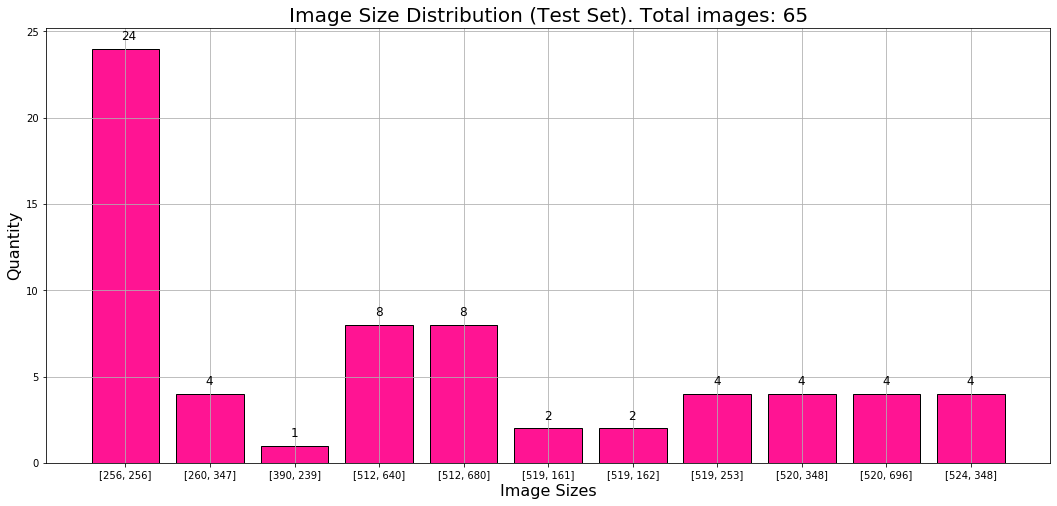

In [19]:
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(18,8))
ax.bar(ts_unique, ts_counts, color='deeppink', edgecolor='black')  # `density=False` would make counts
ax.set_title('Image Size Distribution (Test Set). ' + 'Total images: ' + str(len(ts_size_lst)), fontsize=20)
ax.set_ylabel('Quantity', fontsize=16)
ax.set_xlabel('Image Sizes', fontsize=16);
ax.grid()
for i in range(len(ts_counts)):
    ax.text(i-.05, ts_counts[i]+.5, ts_counts[i], fontsize=12)

The distributions on the train and test sets are certainly skewed, which I guess is expected. There are some image sizes in test set that are not in the training set. These could be of different modality or magnification. There are 7 out of 16 different shapes that are in Test data set only and not in the train data set.

There is a large range of image dimensions in the bouth train and test datasets and not all of the images are square. For the train one the smallest image was 256x256 and the largest was 1040x1388 pixels. Meanwhile test set have only 512x680 as the biggest size. Definitally there must be general resizing pre-processing before fid imagese to model.

Most of the images look like they are 256x256 so the squashing/stretching might not be an issue. Scaling the smaller images up might be a better option than scaling the larger images down as this would also result in a loss of information.

In [20]:
def nuclei_size_stats(image_id):
    mask_paths = os.path.join(train_dir, image_id, 'masks', '*.png')
    masks = skimage.io.imread_collection(mask_paths).concatenate()
    masks = (masks > 0).astype(np.uint16)
    nuclei_sizes = np.sum(masks, axis=(1,2))
    return np.count_nonzero(nuclei_sizes), np.mean(nuclei_sizes), np.min(nuclei_sizes), np.max(nuclei_sizes), np.std(nuclei_sizes)


## Nuclei per image statistics##

Create a pandas data frame from the list of image that was created in the loop above. This will make the data easier to manipulate and plot.

After creating the data frame we can take a look at its summary stats along with the first five and last five rows to make sure it looks ok and get familiar with it.

In [21]:
df_stats = pd.DataFrame(columns=['quantity', 'size_mean', 'size_min', 'size_max', 'size_std'])
for n, image_id in tqdm(enumerate(im_ids), total=len(im_ids)):
    df_stats.loc[len(df_stats)] = nuclei_size_stats(image_id)

100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:36<00:00,  6.96it/s]


In [22]:
df_stats.describe()

,quantity,size_mean,size_min,size_max,size_std
count,670.000000,670.000000,670.000000,670.000000,670.000000
mean,43.971642,560.483462,69.270149,1243.029851,306.627435
std,47.962530,634.752932,197.402043,1346.599675,359.936976
min,1.000000,26.000000,21.000000,26.000000,0.000000
25%,15.250000,150.521825,24.000000,287.250000,65.940617
50%,27.000000,265.434343,33.000000,634.500000,148.111038
75%,54.000000,674.434370,63.000000,1733.000000,394.974610
max,375.000000,7244.071429,4367.000000,11037.000000,1965.426189


## Plotting number of nuclei per image distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002063A00A488>]],
      dtype=object)

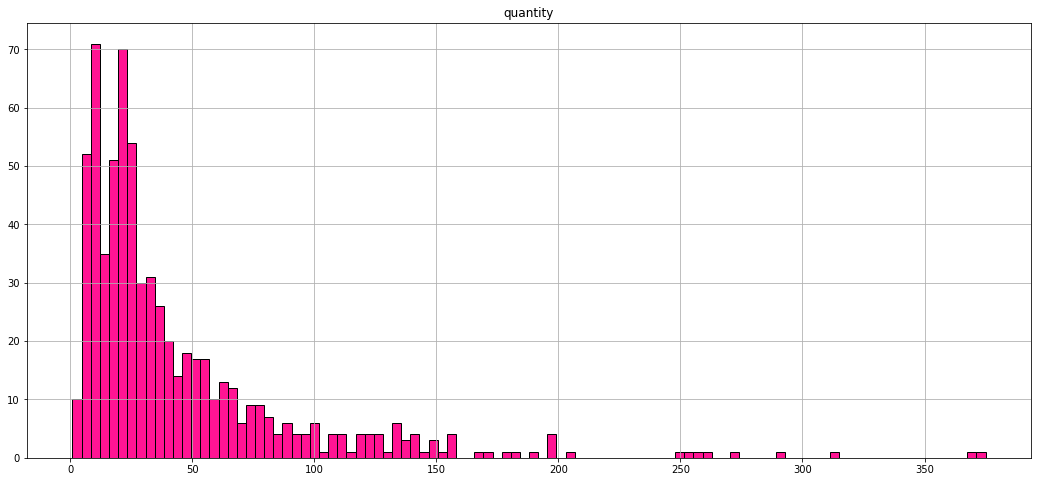

In [23]:
df_stats.hist(column='quantity',
              bins=100, grid=True, figsize=(18,8), color='deeppink', edgecolor='black')

## Plotting nuclei main statistics

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020634E5D3C8>,
      dtype=object)

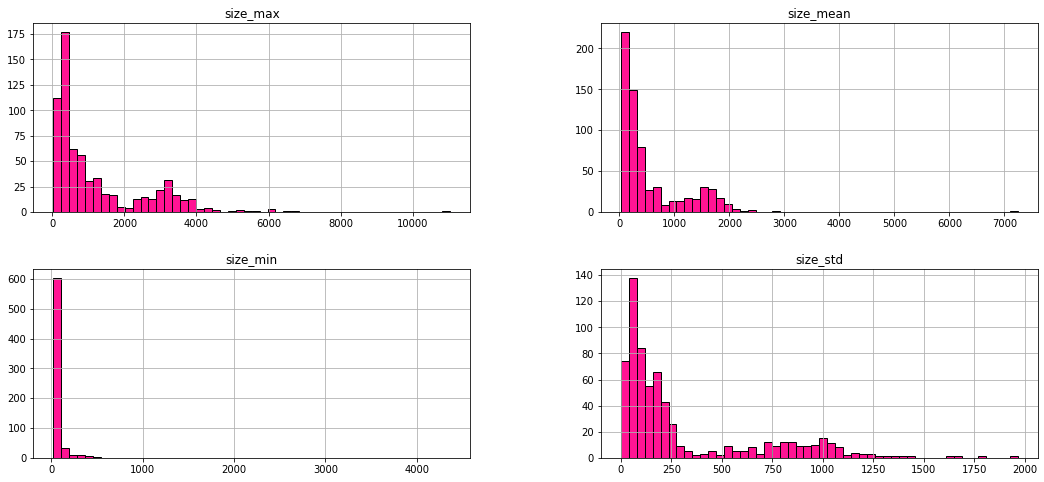

In [24]:
df_stats.hist(column=['size_mean', 'size_min', 'size_max', 'size_std'],
              bins=50, grid=True, figsize=(18,8), color='deeppink', edgecolor='black')

All directories contain at least one mask, so no need to worry about that. Most of them have below 54, but some have as many as 375

## Conclusion##

There is a large range of image dimensions in the dataset and not all of the images are square. The smallest image was 256x256 and the largest was 1040x1388 pixels. The smallest nucleus was only a few pixels in size and was found in one of the larger images (1000x1000), resizing this image caused the tiny nucleus to disappear so resizing images should be approached with great caution. The size of nuclei vary a lot throughout the images in the training set and is likely to make detection more challenging.